<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw4/p1_NeRF_ColorMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1hF4z9U-xaoV4qaq9DbhTP-KKJTlwOUv_ -O hw4_data.zip
!unzip hw4_data.zip
!rm hw4_data.zip

In [ ]:
!gdown 1a-1prjFoFaY_ZK4KriFCKWcqwkdDt5tW -O hw4_gt.zip
!unzip hw4_gt.zip
!rm hw4_gt.zip

In [ ]:
!pip install kornia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### NeRF_pl

In [ ]:
!git clone --recursive https://github.com/kwea123/nerf_pl

#### blender.py

In [ ]:
import torch
from torch.utils.data import Dataset
import json
import numpy as np
import os
import glob
from PIL import Image
from torchvision import transforms as T
import random
from kornia import create_meshgrid
from scipy.spatial import transform


def calculate_near_and_far(rays_o, rays_d, bbox_min=[-1.,-1.,-1.], bbox_max=[1.,1.,1.]):
    '''
    rays_o, (len(self.split_ids)*h*w, 3)
    rays_d, (len(self.split_ids)*h*w, 3)
    bbox_min=[-1,-1,-1],
    bbox_max=[1,1,1]
    '''
    # map all shape to same (len(self.split_ids)*h*w, 3, 2)
    corners = torch.stack((torch.tensor(bbox_min),torch.tensor(bbox_max)), dim=-1)
    corners = corners.unsqueeze(0).repeat(rays_o.shape[0],1,1) # (len(self.split_ids)*h*w, 3, 2)
    corners -= torch.unsqueeze(rays_o, -1).repeat(1,1,2)
    intersections = (corners / (torch.unsqueeze(rays_d, -1).repeat(1,1,2)))

    min_intersections = torch.amax(torch.amin(intersections, dim=-1), dim=-1, keepdim=True)
    max_intersections = torch.amin(torch.amax(intersections, dim=-1), dim=-1, keepdim=True)
    epsilon = 1e-10*torch.ones_like(min_intersections)
    near = torch.maximum(epsilon, min_intersections)
    # tmp = near
    near = torch.where((near > max_intersections), epsilon, near)
    far = torch.where(near < max_intersections, max_intersections, near+epsilon)

    return near, far

def get_ray_directions(H, W, focal):
    """
    Get ray directions for all pixels in camera coordinate.
    Reference: https://www.scratchapixel.com/lessons/3d-basic-rendering/
               ray-tracing-generating-camera-rays/standard-coordinate-systems

    Inputs:
        H, W, focal: image height, width and focal length

    Outputs:
        directions: (H, W, 3), the direction of the rays in camera coordinate
    """
    grid = create_meshgrid(H, W, normalized_coordinates=False)[0]
    i, j = grid.unbind(-1)
    # the direction here is without +0.5 pixel centering as calibration is not so accurate
    # see https://github.com/bmild/nerf/issues/24
    directions = \
        torch.stack([(i-W/2)/focal, -(j-H/2)/focal, -torch.ones_like(i)], -1) # (H, W, 3)

    return directions

def get_rays(directions, c2w):
    """
    Get ray origin and normalized directions in world coordinate for all pixels in one image.
    Reference: https://www.scratchapixel.com/lessons/3d-basic-rendering/
               ray-tracing-generating-camera-rays/standard-coordinate-systems

    Inputs:
        directions: (H, W, 3) precomputed ray directions in camera coordinate
        c2w: (3, 4) transformation matrix from camera coordinate to world coordinate

    Outputs:
        rays_o: (H*W, 3), the origin of the rays in world coordinate
        rays_d: (H*W, 3), the normalized direction of the rays in world coordinate
    """
    # Rotate ray directions from camera coordinate to the world coordinate
    rays_d = directions @ c2w[:, :3].T # (H, W, 3)
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    # The origin of all rays is the camera origin in world coordinate
    rays_o = c2w[:, 3].expand(rays_d.shape) # (H, W, 3)

    rays_d = rays_d.view(-1, 3)
    rays_o = rays_o.view(-1, 3)

    return rays_o, rays_d

def blender_quat2rot(quaternion):
    """Convert quaternion to rotation matrix.
    Equivalent to, but support batched case:
    ```python
    rot3x3 = mathutils.Quaternion(quaternion).to_matrix()
    ```
    Args:
    quaternion:
    Returns:
    rotation matrix
    """

    # Note: Blender first cast to double values for numerical precision while
    # we're using float32.
    q = np.sqrt(2) * quaternion

    q0 = q[..., 0]
    q1 = q[..., 1]
    q2 = q[..., 2]
    q3 = q[..., 3]

    qda = q0 * q1
    qdb = q0 * q2
    qdc = q0 * q3
    qaa = q1 * q1
    qab = q1 * q2
    qac = q1 * q3
    qbb = q2 * q2
    qbc = q2 * q3
    qcc = q3 * q3

    # Note: idx are inverted as blender and numpy convensions do not
    # match (x, y) -> (y, x)
    rotation = np.empty((*quaternion.shape[:-1], 3, 3), dtype=np.float32)
    rotation[..., 0, 0] = 1.0 - qbb - qcc
    rotation[..., 1, 0] = qdc + qab
    rotation[..., 2, 0] = -qdb + qac

    rotation[..., 0, 1] = -qdc + qab
    rotation[..., 1, 1] = 1.0 - qaa - qcc
    rotation[..., 2, 1] = qda + qbc

    rotation[..., 0, 2] = qdb + qac
    rotation[..., 1, 2] = -qda + qbc
    rotation[..., 2, 2] = 1.0 - qaa - qbb
    return rotation

def make_transform_matrix(positions,rotations,):
    """Create the 4x4 transformation matrix.
    Note: This function uses numpy.
    Args:
    positions: Translation applied after the rotation.
        Last column of the transformation matrix
    rotations: Rotation. Top-left 3x3 matrix of the transformation matrix.
    Returns:
    transformation_matrix:
    """
    # Create the 4x4 transformation matrix
    rot_pos = np.broadcast_to(np.eye(4), (*positions.shape[:-1], 4, 4)).copy()
    rot_pos[..., :3, :3] = rotations
    rot_pos[..., :3, 3] = positions
    return rot_pos

def from_position_and_quaternion(positions, quaternions, use_unreal_axes):
    if use_unreal_axes:
        rotations = transform.Rotation.from_quat(quaternions).as_matrix()
    else:
        # Rotation matrix that rotates from world to object coordinates.
        # Warning: Rotations should be given in blender convensions as
        # scipy.transform uses different convensions.
        rotations = blender_quat2rot(quaternions)
    px2world_transform = make_transform_matrix(positions=positions,rotations=rotations)
    return px2world_transform

def scale_rays(all_rays_o, all_rays_d, scene_boundaries, img_wh):
    """Rescale scene boundaries.
    rays_o: (len(image_paths)*h*w, 3)
    rays_d: (len(image_paths)*h*w, 3)
    scene_boundaries: np.array(2 ,3), [min, max]
    img_wh: (2)
    """
    # Rescale (x, y, z) from [min, max] -> [-1, 1]
    all_rays_o = all_rays_o.reshape(-1, img_wh[0], img_wh[1], 3) # (len(image_paths), h, w, 3))
    all_rays_d = all_rays_d.reshape(-1, img_wh[0], img_wh[1], 3)

    old_min = torch.from_numpy(scene_boundaries[0])
    old_max = torch.from_numpy(scene_boundaries[1])
    new_min = torch.tensor([-1,-1,-1])
    new_max = torch.tensor([1,1,1])
    # scale = max(scene_boundaries[1] - scene_boundaries[0])/2
    # all_rays_o = (all_rays_o - torch.mean(all_rays_o, dim=-1, keepdim=True)) / scale
    # This is from jax3d.interp, kind of weird but true
    all_rays_o = ((new_min - new_max) / (old_min - old_max))*all_rays_o + (old_min * new_max - new_min * old_max) / (old_min - old_max)

    # We also need to rescale the camera direction by bbox.size.
    # The direction can be though of a ray from a point in space (the camera
    # origin) to another point in space (say the red light on the lego
    # bulldozer). When we scale the scene in a certain way, this direction
    # also needs to be scaled in the same way.
    all_rays_d = all_rays_d * 2 / (scene_boundaries[1] - scene_boundaries[0])
    # (re)-normalize the rays
    all_rays_d = all_rays_d / torch.linalg.norm(all_rays_d, dim=-1, keepdims=True)
    return all_rays_o.reshape(-1, 3), all_rays_d.reshape(-1, 3)


# Nesf Klevr

class BlenderDataset(Dataset):
    def __init__(self, root_dir, split='train', get_rgb=True) -> None:
        # super().__init__()
        '''
        split: train/val/test
        '''
        self.root_dir = root_dir
        self.get_rgb = get_rgb
        self.split = split

        self.define_transforms()
        self.read_meta()

    def define_transforms(self):
        self.transform = T.ToTensor()

    def read_meta(self):
        with open(os.path.join(self.root_dir, "metadata.json"), "r") as f:
            self.meta = json.load(f)

        w, h = self.meta['metadata']['width'], self.meta['metadata']['width']
        self.img_wh = (w, h)
        self.focal = (self.meta['camera']['focal_length']*w/self.meta['camera']['sensor_width'])
        if self.split not in ['train', 'val', 'test']:
            raise ValueError(f"split should be train/val/test, got {self.split}")
        self.split_ids = self.meta['split_ids'][self.split]

        self.scene_boundaries = np.array([self.meta['scene_boundaries']['min'], self.meta['scene_boundaries']['max']])
        self.directions = get_ray_directions(h, w, self.focal)

        if self.split == 'train':
            self.poses = []
            self.all_rays_o = []
            self.all_rays_d = []
            self.all_rays = []
            self.all_rgbs = []
            camera_positions = np.array(self.meta['camera']['positions'])
            camera_quaternions = np.array(self.meta['camera']['quaternions'])
            for image_id in self.split_ids:
                if self.get_rgb:
                    image_path = os.path.join(self.root_dir, f'{image_id:05d}.png')
                    img = Image.open(image_path)
                    img = img.resize(self.img_wh, Image.Resampling.LANCZOS)
                    img = self.transform(img) # (4, h, w)
                    img = img.view(4, -1).permute(1,0) # (h*w, 4)
                    # not sure, original jax implementation seems not using blend just cut it off, they also /255 to make it [0,1] which I didn't use
                    # img = img[:, :3]*img[:, -1:]+(1-img[:,-1:]) # blend A to RGB
                    img = img[:, :3]
                    self.all_rgbs += [img]

                pose = np.array(from_position_and_quaternion(camera_positions[image_id:image_id+1,:], camera_quaternions[image_id:image_id+1,:], False))[0,:3,:4]
                self.poses += [pose]
                c2w = torch.FloatTensor(pose)
                rays_o, rays_d = get_rays(self.directions, c2w)
                self.all_rays_o += [rays_o]
                self.all_rays_d += [rays_d]

            self.all_rays_o = torch.cat(self.all_rays_o, 0) # (len(self.split_ids)*h*w, 3)
            self.all_rays_d = torch.cat(self.all_rays_d, 0) # (len(self.split_ids)*h*w, 3)
            self.all_rays_o, self.all_rays_d = scale_rays(self.all_rays_o, self.all_rays_d, self.scene_boundaries, self.img_wh)


            self.near, self.far = calculate_near_and_far(self.all_rays_o, self.all_rays_d)
            self.all_rays = torch.cat([self.all_rays_o, self.all_rays_d, self.near, self.far],1).float()

            if len(self.all_rgbs) > 0:
                self.all_rgbs = torch.cat(self.all_rgbs, 0)

    def __len__(self):
        if self.split == 'train':
            return len(self.all_rays)
        elif self.split == 'val' or self.split == 'test':
            return len(self.split_ids)
    def __getitem__(self, idx):
        if self.split == 'train':
            sample = {
                'rays': self.all_rays[idx],
            }
            if self.get_rgb:
                sample['rgbs'] = self.all_rgbs[idx]


        # split of val/test
        elif self.split == 'val':
            image_id = self.split_ids[idx]

            if self.get_rgb:
                img = Image.open(os.path.join(self.root_dir, f'{image_id:05d}.png'))
                img = img.resize(self.img_wh, Image.Resampling.LANCZOS)
                img = self.transform(img)
                valid_mask = (img[-1]>0).flatten()
                img = img.view(4,-1).permute(1,0)
                # img = img[:,:3]*img[:,-1:]+(1-img[:,-1:])
                img = img[:, :3]

            camera_position = np.array(self.meta['camera']['positions'][image_id:image_id+1])
            camera_quaternion = np.array(self.meta['camera']['quaternions'][image_id:image_id+1])

            pose = np.array(from_position_and_quaternion(camera_position, camera_quaternion, False))[0,:3,:4]
            # pose = np.array(from_position_and_quaternion(camera_position[idx:1+idx,:], camera_quaternion[idx:1+idx,:], False))[0,:3,:4]
            c2w = torch.FloatTensor(pose)[:3,:4]
            rays_o, rays_d = get_rays(self.directions, c2w)
            rays_o, rays_d = scale_rays(rays_o, rays_d, self.scene_boundaries, self.img_wh)

            self.near, self.far = calculate_near_and_far(rays_o, rays_d)
            rays = torch.cat([rays_o, rays_d,
                              self.near,
                              self.far],
                              1) # (H*W, 8)

            sample = {'rays': rays.float(),
                      'id': image_id,
                      'c2w': c2w}
            if self.get_rgb:
                sample['rgbs'] = img
                sample['valid_mask'] = valid_mask

        elif self.split == 'test':
            image_id = self.split_ids[idx]

            camera_position = np.array(self.meta['camera']['positions'][image_id:image_id+1])
            camera_quaternion = np.array(self.meta['camera']['quaternions'][image_id:image_id+1])

            pose = np.array(from_position_and_quaternion(camera_position, camera_quaternion, False))[0,:3,:4]
            # pose = np.array(from_position_and_quaternion(camera_position[idx:1+idx,:], camera_quaternion[idx:1+idx,:], False))[0,:3,:4]
            c2w = torch.FloatTensor(pose)[:3,:4]
            rays_o, rays_d = get_rays(self.directions, c2w)
            rays_o, rays_d = scale_rays(rays_o, rays_d, self.scene_boundaries, self.img_wh)

            self.near, self.far = calculate_near_and_far(rays_o, rays_d)
            rays = torch.cat([rays_o, rays_d,
                              self.near,
                              self.far],
                              1) # (H*W, 8)

            sample = {'rays': rays.float(),
                      # 'c2w': c2w,
                      'id': image_id}


        return sample

#### train.py

In [ ]:
import os, sys
from opt import get_opts
import torch
from collections import defaultdict

from torch.utils.data import DataLoader
from datasets import dataset_dict

# models
from models.nerf import Embedding, NeRF
from models.rendering import render_rays

# optimizer, scheduler, visualization
from utils import *

# losses
from losses import loss_dict

# metrics
from metrics import *

# # img save
import matplotlib.pyplot as plt
import numpy as np
import imageio

# pytorch-lightning
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

class NeRFSystem(LightningModule):
    def __init__(self, hparams):
        super(NeRFSystem, self).__init__()
        self.save_hyperparameters(hparams)

        self.loss = loss_dict[hparams.loss_type]()

        self.embedding_xyz = Embedding(3, 10) # 10 is the default number
        self.embedding_dir = Embedding(3, 4) # 4 is the default number
        self.embeddings = [self.embedding_xyz, self.embedding_dir]

        self.nerf_coarse = NeRF()
        self.models = [self.nerf_coarse]
        if hparams.N_importance > 0:
            self.nerf_fine = NeRF()
            self.models += [self.nerf_fine]

    def decode_batch(self, batch):
        rays = batch['rays'] # (B, 8)
        rgbs = batch['rgbs'] # (B, 3)
        return rays, rgbs

    def forward(self, rays):
        """Do batched inference on rays using chunk."""
        B = rays.shape[0]
        results = defaultdict(list)
        for i in range(0, B, self.hparams.chunk):
            rendered_ray_chunks = \
                render_rays(self.models,
                            self.embeddings,
                            rays[i:i+self.hparams.chunk],
                            self.hparams.N_samples,
                            self.hparams.use_disp,
                            self.hparams.perturb,
                            self.hparams.noise_std,
                            self.hparams.N_importance,
                            self.hparams.chunk,) # chunk size is effective in val mode
                            # self.train_dataset.white_back)

            for k, v in rendered_ray_chunks.items():
                results[k] += [v]

        for k, v in results.items():
            results[k] = torch.cat(v, 0)
        return results

    def prepare_data(self):
        dataset = dataset_dict[self.hparams.dataset_name]
        kwargs = {'root_dir': self.hparams.root_dir,
                  } # 'img_wh': tuple(self.hparams.img_wh)
        if self.hparams.dataset_name == 'llff':
            kwargs['spheric_poses'] = self.hparams.spheric_poses
            kwargs['val_num'] = self.hparams.num_gpus
        self.train_dataset = dataset(split='train', **kwargs)
        self.val_dataset = dataset(split='val', **kwargs)

    def configure_optimizers(self):
        self.optimizer = get_optimizer(self.hparams, self.models)
        scheduler = get_scheduler(self.hparams, self.optimizer)

        return [self.optimizer], [scheduler]

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          shuffle=True,
                          num_workers=4,
                          batch_size=self.hparams.batch_size,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          shuffle=False,
                          num_workers=4,
                          batch_size=1, # validate one image (H*W rays) at a time
                          pin_memory=True)

    def training_step(self, batch, batch_nb):
        log = {'lr': get_learning_rate(self.optimizer)}
        rays, rgbs = self.decode_batch(batch)
        results = self(rays)
        log['train/loss'] = loss = self.loss(results, rgbs)
        typ = 'fine' if 'rgb_fine' in results else 'coarse'

        with torch.no_grad():
            psnr_ = psnr(results[f'rgb_{typ}'], rgbs)
            log['train/psnr'] = psnr_

        for k, v in log.items():
            self.log_dict({k: v})

        return {'loss': loss,
                'progress_bar': {'train_psnr': psnr_},
                'log': log
               }

    def validation_step(self, batch, batch_nb):
        rays, rgbs = self.decode_batch(batch)
        img_id = batch['id']
        rays = rays.squeeze() # (H*W, 3)
        rgbs = rgbs.squeeze() # (H*W, 3)
        results = self(rays)
        log = {'val_loss': self.loss(results, rgbs)}

        typ = 'fine' if 'rgb_fine' in results else 'coarse'

        if batch_nb == 0:
            W, H = self.hparams.img_wh
            img = results[f'rgb_{typ}'].view(H, W, 3).cpu()
            img = img.permute(2, 0, 1) # (3, H, W)
            img_gt = rgbs.view(H, W, 3).permute(2, 0, 1).cpu() # (3, H, W)
            depth = visualize_depth(results[f'depth_{typ}'].view(H, W)) # (3, H, W)

            output_path =  f'./depth_img/{int(img_id):05d}.png'
            depth_numpy = depth.permute(1, 2, 0).numpy()
            depth_numpy = (depth_numpy - depth_numpy.min()) / (depth_numpy.max() - depth_numpy.min()) * 255
            depth_numpy = depth_numpy.astype('uint8')
            imageio.imwrite(
                output_path,
                depth_numpy
            )

            stack = torch.stack([img_gt, img, depth]) # (3, 3, H, W)
            self.logger.experiment.add_images('val/GT_pred_depth',
                                               stack, self.global_step)

        log['val_psnr'] = psnr(results[f'rgb_{typ}'], rgbs)
        # 使用 self.log 來記錄 'val/loss'
        for k, v in log.items():
            self.log_dict({k: v})
        return log

if __name__ == '__main__':
    hparams = get_opts()
    system = NeRFSystem(hparams)
    checkpoint_callback = ModelCheckpoint(dirpath='./ckpts',
                                          filename='base',
                                          monitor='val_loss',
                                          mode='min',
                                          save_top_k=5,)

    logger = TensorBoardLogger(
        save_dir="logs",
        name=hparams.exp_name,
        # debug=False,
        # create_git_tag=False
    )

    trainer = Trainer(max_epochs=hparams.num_epochs,
                      callbacks=checkpoint_callback,
                      # resume_from_checkpoint=hparams.ckpt_path,
                      logger=logger,
                      # early_stop_callback=None,
                      # weights_summary=None,
                      # progress_bar_refresh_rate=1,
                      # gpus=hparams.num_gpus,
                      # distributed_backend='ddp' if hparams.num_gpus>1 else None,
                      num_sanity_val_steps=1,
                      benchmark=True,)
                      # profiler=hparams.num_gpus==1)

    trainer.fit(system)

#### training

rendering: torch.searchsorted

In [5]:
cd nerf_pl

/content/nerf_pl


In [6]:
mkdir ckpts

In [7]:
mkdir imgout

In [8]:
mkdir depth_img

In [ ]:
!pip install pytorch-lightning==2.1.2

In [ ]:
!python train.py \
   --dataset_name blender \
   --root_dir '/content/dataset' \
   --N_importance 64 --img_wh 256 256 --noise_std 0 \
   --num_epochs 8 --batch_size 1024 \
   --optimizer adam --lr 5e-4 \
   --lr_scheduler steplr --decay_step 2 4 8 --decay_gamma 0.5 \
   --exp_name exp

#### logs

In [ ]:
!tensorboard --logdir /content/nerf_pl/logs  # logs是你的日誌目錄

In [20]:
!gdown 1-SbMC1KUZ7FMotoQvJP8boJqvqBRDw-o -O base.ckpt

Downloading...
From: https://drive.google.com/uc?id=1-SbMC1KUZ7FMotoQvJP8boJqvqBRDw-o
To: /content/nerf_pl/base.ckpt
100% 14.4M/14.4M [00:00<00:00, 138MB/s]


#### eval.py

In [ ]:
import os, sys
from opt import get_opts
import torch
from collections import defaultdict

from torch.utils.data import DataLoader
from datasets import dataset_dict

# models
from models.nerf import Embedding, NeRF
from models.rendering import render_rays

# optimizer, scheduler, visualization
from utils import *

# losses
from losses import loss_dict

# metrics
from metrics import *

# img save
import matplotlib.pyplot as plt
import numpy as np
import imageio

# pytorch-lightning
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

class NeRFSystem(LightningModule):
    def __init__(self, hparams):
        super(NeRFSystem, self).__init__()
        self.save_hyperparameters(hparams)

        self.loss = loss_dict[hparams.loss_type]()

        self.embedding_xyz = Embedding(3, 10) # 10 is the default number
        self.embedding_dir = Embedding(3, 4) # 4 is the default number
        self.embeddings = [self.embedding_xyz, self.embedding_dir]

        self.nerf_coarse = NeRF()
        self.models = [self.nerf_coarse]
        if hparams.N_importance > 0:
            self.nerf_fine = NeRF()
            self.models += [self.nerf_fine]

    # def decode_batch(self, batch):
    #     rays = batch['rays'] # (B, 8)
    #     rgbs = batch['rgbs'] # (B, 3)
    #     return rays, rgbs

    def forward(self, rays):
        """Do batched inference on rays using chunk."""
        B = rays.shape[0]
        results = defaultdict(list)
        for i in range(0, B, self.hparams.chunk):
            rendered_ray_chunks = \
                render_rays(self.models,
                            self.embeddings,
                            rays[i:i+self.hparams.chunk],
                            self.hparams.N_samples,
                            self.hparams.use_disp,
                            self.hparams.perturb,
                            self.hparams.noise_std,
                            self.hparams.N_importance,
                            self.hparams.chunk,) # chunk size is effective in val mode
                            # self.train_dataset.white_back)

            for k, v in rendered_ray_chunks.items():
                results[k] += [v]

        for k, v in results.items():
            results[k] = torch.cat(v, 0)
        return results

    def prepare_data(self):
        dataset = dataset_dict[self.hparams.dataset_name]
        kwargs = {'root_dir': self.hparams.root_dir,
                  } # 'img_wh': tuple(self.hparams.img_wh)
        if self.hparams.dataset_name == 'llff':
            kwargs['spheric_poses'] = self.hparams.spheric_poses
        self.test_dataset = dataset(split='val', **kwargs)

    def configure_optimizers(self):
        self.optimizer = get_optimizer(self.hparams, self.models)
        scheduler = get_scheduler(self.hparams, self.optimizer)

        return [self.optimizer], [scheduler]

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          shuffle=False,
                          num_workers=4,
                          batch_size=1,
                          pin_memory=True)

    def test_step(self, batch, batch_nb):
        rays = batch['rays']
        img_id = batch['id']
        rays = rays.squeeze() # (H*W, 3)
        results = self(rays)
        typ = 'fine' if 'rgb_fine' in results else 'coarse'

        W, H = self.hparams.img_wh
        img = results[f'rgb_{typ}'].view(H, W, 3).cpu()

        # Save the rendered image for each test batch
        output_path =  f'./imgout/{int(img_id):05d}.png'
        img_vis = (
            img
            .clip(0, 1)
            .numpy()
        )
        imageio.imwrite(
            output_path,
            (img_vis * 255).astype('uint8')
        )

        # Return any relevant metrics or values
        return {'output_image_path': output_path}


    # def validation_epoch_end(self, outputs):
    #     mean_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     mean_psnr = torch.stack([x['val_psnr'] for x in outputs]).mean()

    #     return {'progress_bar': {'val_loss': mean_loss,
    #                              'val_psnr': mean_psnr},
    #             'log': {'val/loss': mean_loss,
    #                     'val/psnr': mean_psnr}
    #            }


if __name__ == '__main__':
    hparams = get_opts()
    system = NeRFSystem(hparams)
    checkpoint_callback = ModelCheckpoint(dirpath='./ckpts',
                                          filename='base.ckpt',
                                          monitor='val/loss',
                                          mode='min',
                                          save_top_k=5,)

    logger = TensorBoardLogger(
        save_dir="logs",
        name=hparams.exp_name,
    )

    trainer = Trainer(max_epochs=hparams.num_epochs,
                      callbacks=checkpoint_callback,
                      # resume_from_checkpoint=hparams.ckpt_path,
                      logger=logger,
                      # early_stop_callback=None,
                      # weights_summary=None,
                      # progress_bar_refresh_rate=1,
                      # gpus=hparams.num_gpus,
                      # distributed_backend='ddp' if hparams.num_gpus>1 else None,
                      num_sanity_val_steps=1,
                      benchmark=True,)
                      # profiler=hparams.num_gpus==1)

    # Load the best checkpoint for testing
    trainer.test(system, ckpt_path='./ckpts/base.ckpt')

#### testing

In [21]:
!python3 eval.py \
   --root_dir '/content/dataset' \
   --dataset_name blender \
   --img_wh 256 256 --N_importance 64 --noise_std 0

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-12-10 16:01:47.707063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 16:01:47.707120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 16:01:47.707162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 16:01:48.839275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Restoring states from the checkpoint path at ./ckpts/base.ckpt
LOCAL_RANK: 0 - CUDA_VI

In [33]:
cd ..

/content


In [35]:
!python3 grade.py /content/nerf_pl/imgout /content/val_gt

100% 20/20 [00:02<00:00,  7.15it/s]
Testing psnr 42.183295011520386 (avg)
Testing ssim 0.9924355388185437 (avg)


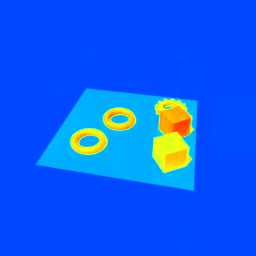

True

In [32]:
import cv2
import numpy as np
from PIL import Image
import imageio
from google.colab.patches import cv2_imshow

image = Image.open('/content/nerf_pl/imgout/00279.png')

# 将深度图映射为彩色图
colored_depth = cv2.applyColorMap(np.uint8(np.array(image) * 255), cv2.COLORMAP_JET)
cv2_imshow(colored_depth)
cv2.imwrite('/content/nerf_pl/depth_img/00279.png', colored_depth)